In [113]:
from SynTemp.SynUtils.utils import load_database, load_from_pickle
data = load_from_pickle('./Data/uspto/uspto_its_graph_rules_cluster.pkl.gz')

In [114]:
from SynTemp.SynMØD.naive_cluster import NaiveCluster
node_label_names = ["element", "charge"]
naive_cluster = NaiveCluster(node_label_names=node_label_names, node_label_default=["*", 0], edge_attribute="order")
its_graph_rules_cluster = naive_cluster.process_rules_clustering(data, rule_column='GraphRules')

In [115]:
its_graph_rules_cluster[0]

{'R-id': 'USPTO_50K_26',
 'ITSGraph': (<networkx.classes.graph.Graph at 0x7f244bb60390>,
  <networkx.classes.graph.Graph at 0x7f244b6d5050>),
 'GraphRules': (<networkx.classes.graph.Graph at 0x7f244b817c90>,
  <networkx.classes.graph.Graph at 0x7f244b808410>),
 'naive_cluster': 0,
 'Reaction Type': 'Single Cyclic',
 'Rings': [4]}

In [122]:
from SynTemp.SynUtils.utils import stratified_random_sample
import pandas as pd
sampled_data = stratified_random_sample(its_graph_rules_cluster, property_key='naive_cluster', samples_per_class=1, seed=23)
pd.DataFrame(sampled_data)['Reaction Type'].value_counts()

Reaction Type
Single Cyclic     119
None               39
Complex Cyclic     20
Acyclic            17
Name: count, dtype: int64

In [123]:
single = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Single Cyclic']
complex = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Complex Cyclic']
neither = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'None']
acyclic = [x['GraphRules'][2] for x in sampled_data if x['Reaction Type'] == 'Acyclic']

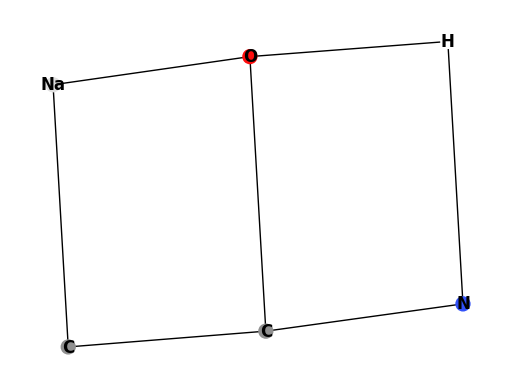

In [125]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer()
vis.graph_vis(complex[4], show_node_labels=True)

In [214]:
import networkx as nx
import numpy as np
from typing import Any, Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from copy import deepcopy
class GrapRuleDecompose:
    @staticmethod
    def get_key_by_value(dictionary: Dict[Any, Any], value: Any) -> Optional[Any]:
        """
        Retrieve a key in a dictionary corresponding to a specified value.

        Parameters:
        - dictionary (Dict[Any, Any]): The dictionary to search through.
        - value (Any): The value to find the corresponding key for.

        Returns:
        - Optional[Any]: The key associated with the specified value, or None if not found.
        """
        return next((key for key, val in dictionary.items() if val == value), None)

    @staticmethod
    def is_connected(graph: nx.Graph) -> bool:
        """
        Check if the given graph is connected.

        Parameters:
        - graph (nx.Graph): The graph to check.

        Returns:
        - bool: True if the graph is connected, False otherwise.
        """
        return nx.is_connected(graph)

    @staticmethod
    def remove_disconnected_part(graph: nx.Graph) -> nx.Graph:
        """
        Remove the smaller disconnected components from a graph, leaving only the largest connected component.
        This function now works on a copy of the original graph, leaving the original graph unmodified.

        Parameters:
        - graph (nx.Graph): The original graph to analyze.

        Returns:
        - nx.Graph: A new graph, which is a copy of the original but with only the largest connected component.
        """
        # Create a copy of the original graph to work with
        graph_copy = deepcopy(graph)
        # Check if the graph is connected; if not, proceed to find and keep only the largest connected component
        if not nx.is_connected(graph_copy):
            components = list(nx.connected_components(graph_copy))
            largest_component = max(components, key=len)
            nodes_to_remove = [node for node in graph_copy.nodes() if node not in largest_component]
            graph_copy.remove_nodes_from(nodes_to_remove)
        
        return graph_copy

    @staticmethod
    def node_match(node1_attrs: Dict[str, Any], node2_attrs: Dict[str, Any]) -> bool:
        """
        Determine whether two nodes match based on their attributes.

        Parameters:
        - node1_attrs (Dict[str, Any]): Attributes of the first node.
        - node2_attrs (Dict[str, Any]): Attributes of the second node.

        Returns:
        - bool: True if nodes match based on the specified criteria, False otherwise.
        """
        return (
            node1_attrs.get('element', None) == node2_attrs.get('element', None) and
            node1_attrs.get('charge', None) == node2_attrs.get('charge', None) and
            node1_attrs.get('aromatic', None) == node2_attrs.get('aromatic', None)
        )

    @staticmethod
    def edge_match(edge1_attrs: Dict[str, Any], edge2_attrs: Dict[str, Any]) -> bool:
        """
        Determine whether two edges match based on their attributes.

        Parameters:
        - edge1_attrs (Dict[str, Any]): Attributes of the first edge.
        - edge2_attrs (Dict[str, Any]): Attributes of the second edge.

        Returns:
        - bool: True if edges match based on the specified criteria, False otherwise.
        """
        order1 = edge1_attrs.get('standard_order', 0)
        order2 = edge2_attrs.get('standard_order', 0)
        return (np.sign(order1) == np.sign(order2)) if (order1 != 0 and order2 != 0) else True
   
    @staticmethod
    def find_maximum_common_subgraph(
        parent_graph: nx.Graph, 
        child_graph: nx.Graph, 
        node_match: callable = None, 
        edge_match: callable = None
    ) -> Optional[Dict]:
        """
        Finds the largest common subgraph between a parent and a child graph based on specified node and edge matching criteria.
        The function uses the VF2 algorithm for graph isomorphism testing and subgraph search to find the largest common subgraph.

        Parameters:
        - parent_graph (nx.Graph): The parent graph in which to find the subgraph.
        - child_graph (nx.Graph): The child graph representing the potential subgraph.
        - node_match (callable, optional): A function used to determine whether nodes in the two graphs match. Defaults to None, which considers all nodes as matching.
        - edge_match (callable, optional): A function used to determine whether edges in the two graphs match. Defaults to None, which considers all edges as matching.

        Returns:
        - Optional[Dict]: A dictionary representing the mapping of nodes in the parent graph to nodes in the child graph for the largest common subgraph. Returns None if no common subgraph is found.

        Example:
        - node_match could be a function that checks if nodes have the same label.
        - edge_match could be a function that checks if edges have the same weight.
        """
        # Initialize the graph matcher with the provided node and edge match functions
        matcher = nx.algorithms.isomorphism.GraphMatcher(parent_graph, child_graph, node_match=node_match, edge_match=edge_match)
        
        # Initialize variables to keep track of the largest common subgraph found
        max_common_subgraph = None
        max_size = 0

        # Iterate over all subgraph isomorphisms
        for isomorphism in matcher.subgraph_isomorphisms_iter():
            current_size = len(isomorphism)
            # Update the maximum common subgraph if a larger one is found
            if current_size > max_size:
                max_size = current_size
                max_common_subgraph = isomorphism

        # Return the largest common subgraph mapping or None if no common subgraph is found
        return max_common_subgraph
    
    @staticmethod
    def remove_maximum_common_subgraph_edges(parent_graph: nx.Graph, child_graph: nx.Graph, 
                                             subgraph_isomorphism: dict, edge_order: str = 'standard_order') -> nx.Graph:
        """
        Creates a modified copy of the parent graph by adjusting edges based on the maximum common subgraph shared with a child graph.
        For each edge in the common subgraph, the method checks a specified edge attribute (defaulting to 'standard_order'):
        - If the attribute value in the parent graph is greater or equal and their signs are the same, the edge is removed.
        - If the attribute value in the parent graph is greater, it's decreased by the value in the child graph.

        Parameters:
        - parent_graph (nx.Graph): The original graph from which edges will be modified.
        - child_graph (nx.Graph): The graph containing the subgraph shared with the parent.
        - subgraph_isomorphism (dict): Node mapping from the parent graph to the child graph for the maximum common subgraph.
        - edge_order (str): The edge attribute to consider for modification (default 'standard_order').

        Returns:
        - nx.Graph: A new graph, modified based on the criteria described above.
        """
        # Create a copy of the parent graph to modify
        parent_graph_copy = parent_graph.copy()

        # Iterate over each edge in the child graph that is part of the common subgraph
        for u, v, data in child_graph.edges(data=True):
            # Find corresponding parent nodes for child nodes u and v
            parent_u = GrapRuleDecompose.get_key_by_value(subgraph_isomorphism, u)
            parent_v = GrapRuleDecompose.get_key_by_value(subgraph_isomorphism, v)

            if parent_u is not None and parent_v is not None and parent_graph_copy.has_edge(parent_u, parent_v):
                parent_edge_data = parent_graph_copy.get_edge_data(parent_u, parent_v)

                # Check if the specified edge attribute exists in both child and parent edges
                if edge_order in data and edge_order in parent_edge_data:
                    # Compare attribute values and their signs
                    if np.sign(data[edge_order]) == np.sign(parent_edge_data[edge_order]) and parent_edge_data[edge_order] >= data[edge_order]:
                        parent_graph_copy.remove_edge(parent_u, parent_v)

                        if abs(parent_edge_data[edge_order]) > abs(data[edge_order]):
                            # If the attribute value in the parent is greater, decrease it instead of removing the edge
                            parent_graph_copy.add_edge(parent_u, parent_v, **{edge_order: parent_edge_data[edge_order] - data[edge_order]})

        # Optionally, remove disconnected components, keeping only the largest connected component
        parent_graph_copy = GrapRuleDecompose.remove_disconnected_part(parent_graph_copy)

        return parent_graph_copy


    @staticmethod
    def dfs_remove_isomorphic_subgraphs(complex_graph: nx.Graph, single_cyclic_graphs: List[nx.Graph], 
                                       edge_order: str = 'standard_order') -> Optional[List[nx.Graph]]:
        """
        Recursively remove isomorphic subgraphs from a complex graph using depth-first search.

        Parameters:
        - complex_graph (nx.Graph): The complex graph to decompose.
        - single_cyclic_graphs (List[nx.Graph]): List of single cyclic graphs to match and remove.
        - edge_order (str): The edge attribute to consider for modification (default 'standard_order').

        Returns:
        - Optional[List[nx.Graph]]: List of single cyclic graphs that explain the complex graph, or None if no solution is found.
        """
        explained_graphs = []
        if not complex_graph.edges():
            return explained_graphs

        for single_graph in single_cyclic_graphs:
            isomorph = GrapRuleDecompose.find_maximum_common_subgraph(complex_graph, single_graph, node_match=GrapRuleDecompose.node_match, 
                                                             edge_match=GrapRuleDecompose.edge_match)
            if isomorph:
                complex_graph_copy = nx.Graph(complex_graph)
                complex_graph_copy = GrapRuleDecompose.remove_maximum_common_subgraph_edges(complex_graph_copy, single_graph, isomorph, edge_order)
                result = GrapRuleDecompose.dfs_remove_isomorphic_subgraphs(complex_graph_copy, single_cyclic_graphs, explained_graphs + [single_graph], edge_order)
                if result is not None:
                    return result

        return None

    @staticmethod
    def bfs_remove_isomorphic_subgraphs(complex_graph: nx.Graph, single_cyclic_graphs: List[nx.Graph], edge_order: str = 'standard_order') -> Optional[List[nx.Graph]]:
        """
        Iteratively remove isomorphic subgraphs from a complex graph using breadth-first search.

        Parameters:
        - complex_graph (nx.Graph): The complex graph to decompose.
        - single_cyclic_graphs (List[nx.Graph]): List of single cyclic graphs to match and remove.
        - edge_order (str): The edge attribute to consider for modification (default 'standard_order').

        Returns:
        - Optional[List[nx.Graph]]: List of single cyclic graphs that explain the complex graph, or None if no solution is found.
        """
        queue = deque([(complex_graph, [])])
        while queue:
            current_graph, explained_graphs = queue.popleft()  # Dequeue
            if not current_graph.edges():
                return explained_graphs

            for single_graph in single_cyclic_graphs:
                isomorph = GrapRuleDecompose.find_maximum_common_subgraph(current_graph, single_graph, node_match=GrapRuleDecompose.node_match, edge_match=GrapRuleDecompose.edge_match)
                if isomorph:
                    complex_graph_copy = GrapRuleDecompose.remove_maximum_common_subgraph_edges(current_graph.copy(), single_graph, isomorph, edge_order)
                    queue.append((complex_graph_copy, explained_graphs + [single_graph]))  # Enqueue

        return None

    @staticmethod
    def visualize_with_common_subgraphs(parent_graph: nx.Graph, child_graphs: List[nx.Graph], seed: int = 42) -> None:
        """
        Visualizes a parent graph alongside two child graphs, highlighting common subgraphs between each child and the parent.

        This method creates a 1x3 subplot: the first two subplots display the child graphs with common subgraph edges highlighted, and the third subplot displays the parent graph with edges common to each child graph highlighted in distinct colors. Edges common to both child graphs and the parent graph are highlighted in a separate color to indicate overlap.

        Parameters:
        - parent_graph (nx.Graph): The parent graph in which common subgraphs are to be identified.
        - child_graphs (List[nx.Graph]): A list containing exactly two child graphs to compare against the parent graph.
        - seed (int, optional): The seed for the layout algorithm to ensure consistent positioning of nodes across plots. Defaults to 42.

        Returns:
        - None
        """
        if len(child_graphs) != 2:
            print("This function requires exactly two child graphs.")
            return
        highlighted_edges = [] 
        sns.set()
        plt.figure(figsize=(15, 5))
        node_color = '#1f78b4'  # Blue for nodes
        parent_edge_color = '#999999'  # Grey for parent edges not in common subgraphs
        common_colors = ['#e31a1c', '#33a02c']  # Red for common subgraph with child 1, Green for child 2
        overlap_color = '#ff8c00'  # Orange for overlapping common subgraphs

        for i, child_graph in enumerate(child_graphs, 1):
            plt.subplot(1, 3, i)
            pos = nx.spring_layout(child_graph, seed=seed)  # Compute layout
            # Draw all nodes
            nx.draw_networkx_nodes(child_graph, pos, node_color=node_color, node_size=500)
            # Draw all edges in default color first
            nx.draw_networkx_edges(child_graph, pos, edge_color='lightgrey', width=1)
            # Highlight common subgraph edges

            #Extracting the 'element' attribute for node labels, if it exists
            node_labels = {node: data.get('element', node) for node, data in child_graph.nodes(data=True)}
            nx.draw_networkx_labels(child_graph, pos, labels=node_labels)
            #matcher = nx.algorithms.isomorphism.GraphMatcher(parent_graph, child_graph, node_match=node_match, edge_match=edge_match)
            subgraph_isomorphism = GrapRuleDecompose.find_maximum_common_subgraph(parent_graph, child_graph, node_match=GrapRuleDecompose.node_match, 
                                                                                  edge_match=GrapRuleDecompose.edge_match)
            if subgraph_isomorphism:
                inverse_isomorphism = {v: u for u, v in subgraph_isomorphism.items()}  # Invert mapping for child to parent
                common_edges = [(u, v) for u, v in child_graph.edges() if u in inverse_isomorphism and v in inverse_isomorphism]
                nx.draw_networkx_edges(child_graph, pos, edgelist=common_edges, edge_color=common_colors[i-1], width=2)
            plt.title(f"Single Rule {i}")

        plt.subplot(1, 3, 3)
        pos = nx.spring_layout(parent_graph, seed = seed)
        # Draw all nodes in the parent graph
        nx.draw_networkx_nodes(parent_graph, pos, node_color=node_color, node_size=500)
        # Draw all edges in the parent graph in default color
        nx.draw_networkx_edges(parent_graph, pos, edge_color=parent_edge_color, width=1)
        # Draw node labels for the parent graph
        # Extracting the 'element' attribute for node labels in the parent graph, if it exists
        parent_node_labels = {node: data.get('element', node) for node, data in parent_graph.nodes(data=True)}
        nx.draw_networkx_labels(parent_graph, pos, labels=parent_node_labels)

        current_graph = deepcopy(parent_graph)
        for i, child_graph in enumerate(child_graphs):
            subgraph_isomorphism = GrapRuleDecompose.find_maximum_common_subgraph(current_graph, child_graph, node_match=GrapRuleDecompose.node_match, 
                                                                                  edge_match=GrapRuleDecompose.edge_match)
            print(subgraph_isomorphism)
            if subgraph_isomorphism:
                common_edges = []
                for u, v in child_graph.edges():
                    complex_u, complex_v = GrapRuleDecompose.get_key_by_value(subgraph_isomorphism, u), GrapRuleDecompose.get_key_by_value(subgraph_isomorphism, v)
                    edge = tuple(sorted([complex_u, complex_v]))
                    if parent_graph.has_edge(*edge):
                        common_edges.append(edge)
                for edge in common_edges:
                    if edge in highlighted_edges:
                        # Edge is an overlap, color it orange
                        nx.draw_networkx_edges(parent_graph, pos, edgelist=[edge], edge_color=overlap_color, width=2)
                    else:
                        # Color edge with child-specific color and add it to the tracking list
                        nx.draw_networkx_edges(parent_graph, pos, edgelist=[edge], edge_color=common_colors[i], width=2)
                        highlighted_edges.append(edge)
                print(current_graph)
                current_graph = GrapRuleDecompose.remove_maximum_common_subgraph_edges(current_graph,child_graph,subgraph_isomorphism)
                #print(current_graph)
            print('***')
        plt.title("Complex Rules")
        plt.show()

List of single cyclic graphs that explain the complex graph: [<networkx.classes.graph.Graph object at 0x7f24a51d96d0>, <networkx.classes.graph.Graph object at 0x7f24a49f2fd0>]
{22: 9, 9: 2, 32: 3, 34: 17}
Graph with 6 nodes and 7 edges
***
{33: 40, 32: 1, 9: 3, 8: 4}
Graph with 4 nodes and 4 edges
***


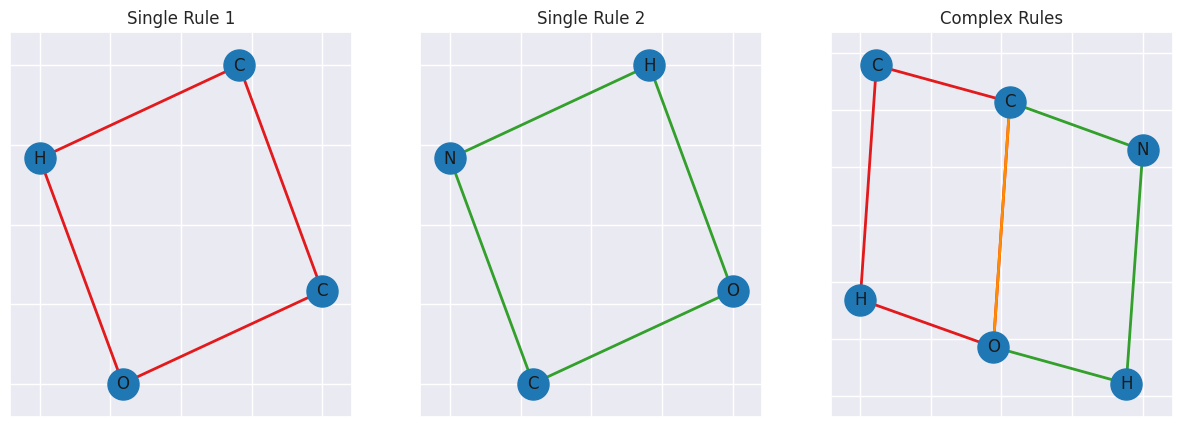

In [215]:
from copy import deepcopy
complex_graph = complex[11]
# Add nodes and edges to complex_graph with the required attributes

single_cyclic_graphs = deepcopy(single)
# Define your single cyclic graphs by adding nodes and edges with the required attributes

# Call the function
explained_graphs = GrapRuleDecompose.bfs_remove_isomorphic_subgraphs(complex_graph, single_cyclic_graphs)

if explained_graphs is not None:
    print("List of single cyclic graphs that explain the complex graph:", explained_graphs)
    GrapRuleDecompose.visualize_with_common_subgraphs(complex_graph, explained_graphs)
else:
    print("Some parts of the complex graph could not be explained by any of the single cyclic graphs.")

In [157]:
print(complex_graph)

Graph with 6 nodes and 7 edges


{10: 26, 12: 27, 3: 12, 8: 13}
Graph with 7 nodes and 8 edges
***
{11: 26, 13: 27, 3: 12, 4: 13}
Graph with 4 nodes and 4 edges
***


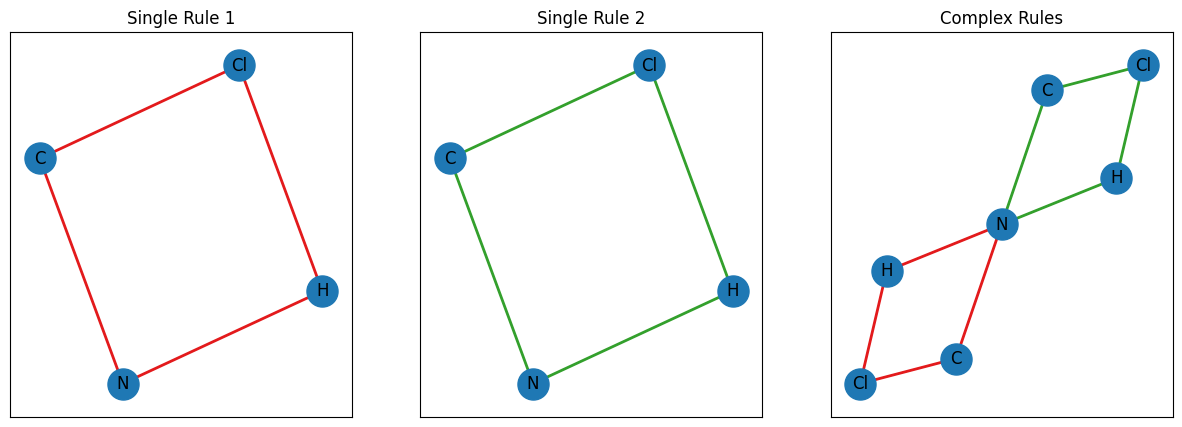

In [155]:
GrapRuleDecompose.visualize_with_common_subgraphs(complex_graph, explained_graphs)

In [205]:
explained_graphs[0].edges(data=True)

EdgeDataView([(9, 17, {'order': (1.0, 0), 'standard_order': 1.0}), (9, 2, {'order': (0, 1.0), 'standard_order': -1.0}), (2, 3, {'order': (1.0, 0), 'standard_order': 1.0}), (3, 17, {'order': (0, 1.0), 'standard_order': -1.0})])

In [ ]:
data = pd.read_csv('./Data/USPTO_sampled.csv', index_col=0).to_dict('records')
data[0]

In [ ]:
from SynTemp.SynITS.its_extraction import ITSExtraction
mapper_name = ['RXNMapper', 'GraphMapper', 'LocalMapper']
its_graph, its_graph_wrong = ITSExtraction.parallel_process_smiles(data, mapper_name, threshold=2, n_jobs=5, verbose=1, export_full=False, check_method='RC')
len(its_graph)

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results = AMMValidator.validate_smiles(data=data, ground_truth_col='LocalMapper', 
                                       mapped_cols=['RXNMapper', 'GraphMapper'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0)

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
from SynTemp.SynAAM.aam_validator import AMMValidator  
results = AMMValidator.validate_smiles(data=data, ground_truth_col='Ground turth', 
                                       mapped_cols=['RXNMapper', 'GraphMapper', 'LocalMapper'], 
                                       check_method='RC', 
                                       ignore_aromaticity=False, n_jobs=4, verbose=0)

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
pd.DataFrame(results)[['mapper', 'accuracy']]

In [ ]:
import pandas as pd
from SynTemp.SynUtils.utils import load_database, save_database, load_from_pickle

df = pd.read_csv('./Data/uspto_sample/uspto_sample.csv')
df.rename(columns={'sampled_id':'R-id', 'RXNMapper':'rxn_mapper', "GraphMapper": "graphormer",
                   "LocalMapper": "local_mapper"}, inplace=True)
df = df[['R-id','rxn_mapper', 'graphormer', 'local_mapper']].to_dict('records')

save_database(df, './Data/uspto_sample/uspto_sample_aam_reactions.json.gz')

In [ ]:
data = load_from_pickle('./Data/uspto_sample/uspto_sample_its_graph_rules_cluster.pkl.gz')

In [ ]:
data = [value for value in data if value['Reaction Type'] == 'Single Cyclic']


In [ ]:
id =30602
test = [value for value in df if value['R-id']==id]
test

In [ ]:
from SynTemp.SynVis.reaction_visualizer import ReactionVisualizer
reaction_vis = ReactionVisualizer()

reaction_vis.visualize_reaction(test[0]['graphormer'])

In [ ]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis_graph = ChemicalGraphVisualizer()

vis_graph.visualize_all([value for value in data if value['R-id']==id][0]['ITSGraph'])

In [ ]:
vis_graph.visualize_all([value for value in data if value['R-id']==id][0]['GraphRules'])

In [ ]:
from SynTemp.SynMØD.MØD_rules import MØDRules
process_graphs = [value for value in data if value['R-id']==id]
results = MØDRules.auto_extraction(process_graphs, reindex=True, save_path='./Data/uspto_sample', rule_column='GraphRules')
print(results[0])

In [ ]:
from rdkit import Chem
chiral_smiles = 'CC[C@@H](C)O'
chiral_mol = Chem.MolFromSmiles(chiral_smiles)
chiral_atom = chiral_mol.GetAtomWithIdx(1) 

In [ ]:
chiral_mol

In [ ]:
Chem.MolFromSmiles('C[N+](C)(C)C.[Cl-]')